In [1]:
%load_ext autoreload
%autoreload 2

# Ruggedness metric

Questions
1. What is the topological stability of a circuit?
2. What is the ruggedness of each circuit generated by the model?

In [2]:
from sklearn.manifold import TSNE
import itertools
from functools import partial
import json
import jax.numpy as jnp
import numpy as np
import os
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.scripts.verify import verify, setup_model, make_rates, prep_sim, sim, prep_cfg, make_batch_symmetrical_matrices
from evoscaper.utils.math import arrayise


jax.config.update('jax_platform_name', 'gpu')


# jupyter nbconvert --to notebook --execute 07_ruggedness.ipynb --output=07_ruggedness_2.ipynb --ExecutePreprocessor.timeout=-1

In [3]:
use_loaded = True
top_write_dir = os.path.join('data', '07_ruggedness', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

dir_src = os.path.join('data', '01_cvae', '2025_01_23__15_38_01')
hpos = pd.Series(load_json_as_dict(os.path.join(dir_src, 'hpos_all.json')))
fn_saves = os.path.join(dir_src, 'saves_2025_01_23__15_38_01_sens')

In [4]:
saves_loaded = load_json_as_dict(fn_saves)

(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = arrayise(saves_loaded[str(list(saves_loaded.keys())[-1])]['params'])



xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


In [5]:
config_bio = load_json_as_dict(config_dataset.filenames_verify_config)
config_bio_u = config_bio['base_configs_ensemble']['generate_species_templates']
config_bio_u.update(config_bio['base_configs_ensemble']['mutation_effect_on_interactions_signal'])
input_species = data[data['sample_name'].notna()]['sample_name'].unique()
config_bio = prep_cfg(config_bio_u, input_species)

# Run verification

In [119]:
if use_loaded:
    analytics = load_json_as_dict(
        'data/02_cvae_verify/2025_01_24__14_05_18/analytics.json')
    fake_circuits = np.load('data/02_cvae_verify/2025_01_24__14_05_18/fake_circuits.npy')
    ts = np.load('data/02_cvae_verify/2025_01_24__14_05_18/ts.npy')
    y0m = np.load('data/02_cvae_verify/2025_01_24__14_05_18/y0m.npy')
    ys = np.load('data/02_cvae_verify/2025_01_24__14_05_18/ys.npy')
    sampled_cond = np.load('data/02_cvae_verify/2025_01_24__14_05_18/sampled_cond.npy')
else:
    (
        analytics, ys, ts, y0m, y00s, ts0, fake_circuits, reverse_rates, model_brn, qreactions, ordered_species, input_species, z, sampled_cond
    ) = verify(params=params,
               rng=rng,
               decoder=decoder,
               df=df,
               cond=np.array([-0.1, 1.1]),
               config_bio=config_bio,
               config_norm_y=config_norm_y,
               config_dataset=config_dataset,
               config_model=config_model,
               x_datanormaliser=x_datanormaliser,
               x_methods_preprocessing=x_methods_preprocessing,
               y_datanormaliser=y_datanormaliser,
               output_species=config_dataset.output_species,
               signal_species=config_dataset.signal_species,
               input_species=data[data['sample_name'].notna()
                                  ]['sample_name'].unique(),
               n_to_sample=int(hpos['eval_n_to_sample']),
               visualise=False,
               top_write_dir=top_write_dir,
               return_relevant=True,
               impose_final_range=(df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].min().min(),
                                   df[get_true_interaction_cols(df, config_dataset.x_type, remove_symmetrical=True, num_species=3)].max().max()))

# Ruggedness functions

In [7]:
def calculate_ruggedness(interactions, eps_perc, analytics_original, analytic, input_species, config_dataset, config_bio):

    eps = eps_perc * np.abs(interactions).max()
    perturbations = jax.vmap(
        partial(create_perturbations, eps=eps))(interactions)

    analytics_perturbed, ys, ts, y0m, y00s, ts0 = simulate_perturbations(
        perturbations, config_dataset, config_bio, input_species)
    analytic_perturbed = jnp.array(
        analytics_perturbed[analytic]).reshape(*interactions.shape, -1)

    ruggedness = jax.vmap(partial(calculate_ruggedness_from_perturbations, eps=eps))(
        analytic_perturbed, np.array(analytics_original[analytic])[:interactions.shape[0]][:, None, :])

    return ruggedness, (analytics_perturbed, ys, ts, y0m, y00s, ts0)


def create_perturbations(interactions, eps):

    interactions_expanded = jnp.ones(
        (len(interactions), len(interactions))) * interactions

    perturbations = interactions_expanded + \
        jnp.eye(len(interactions_expanded), len(interactions_expanded)) * eps

    return perturbations


def simulate_perturbations(interactions, config_dataset, config_bio, input_species):

    interactions_reshaped = make_batch_symmetrical_matrices(
        interactions.reshape(-1, interactions.shape[-1]), side_length=len(input_species))

    model_brn, qreactions, ordered_species, postproc = setup_model(
        interactions_reshaped, config_bio, input_species)

    forward_rates, reverse_rates = make_rates(
        config_dataset.x_type, interactions_reshaped, postproc)

    (signal_onehot, signal_target, y00, t0, t1, dt0, dt1, stepsize_controller, save_steps, max_steps, forward_rates, reverse_rates) = prep_sim(
        config_dataset.signal_species, qreactions, interactions_reshaped, config_bio, forward_rates, reverse_rates)

    #
    threshold = 0.01  # config_bio['simulation']['threshold_steady_states']
    #

    analytics, ys, ts, y0m, y00s, ts0 = sim(y00, forward_rates[0], reverse_rates,
                                            qreactions,
                                            signal_onehot, signal_target,
                                            t0, t1, dt0, dt1,
                                            save_steps, max_steps,
                                            stepsize_controller,
                                            threshold=threshold)
    analytics['Log sensitivity'] = np.log10(analytics['sensitivity_wrt_species-6'])
    analytics['Log precision'] = np.log10(analytics['precision_wrt_species-6'])

    return analytics, ys, ts, y0m, y00s, ts0


def calculate_ruggedness_from_perturbations(analytic_perturbed, analytic_og, eps):

    dp = (analytic_perturbed - analytic_og) / eps

    ruggedness = jnp.sqrt(jnp.nansum(jnp.square(dp), axis=0))

    return ruggedness

In [ ]:
fake_circuits_f = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)

eps_perc = - 1e-2
eps = eps_perc * np.abs(fake_circuits_f).max()
print('eps:', eps)

analytic_key = 'Log sensitivity' 
if 'Log sensitivity' not in analytics:
    analytics['Log sensitivity'] = np.log10(analytics['sensitivity_wrt_species-6'])
    analytics['Log precision'] = np.log10(analytics['precision_wrt_species-6'])
    
ruggedness, _ = calculate_ruggedness(fake_circuits_f, eps_perc=eps_perc, analytics_original=analytics, analytic='Log sensitivity',
                                     input_species=input_species, config_dataset=config_dataset, config_bio=config_bio)

eps: -0.29999998
Steady states found. Now calculating signal response


In [40]:
np.save(os.path.join(top_write_dir, 'ruggedness.npy'), ruggedness)
for i, l in zip(_[1:], ['ys.npy', 'ts.npy', 'y0m.npy', 'y00s.npy', 'ts0.npy']):
    np.save(os.path.join(top_write_dir, l), i)
write_json(_[0], os.path.join(top_write_dir, 'analytics.json'))
# json.dump(_[0], open(os.path.join(top_write_dir, 'analytics.json'), 'w'))
print(top_write_dir)

data/07_ruggedness/2025_01_26__13_32_02


# Visualise

/tmp/ipykernel_1186065/2618675031.py:3: RuntimeWarning: divide by zero encountered in log10
  ruggedness_log = np.where(np.abs(np.log10(ruggedness_loaded)) < np.inf, np.log10(ruggedness_loaded), -6)


([], [])

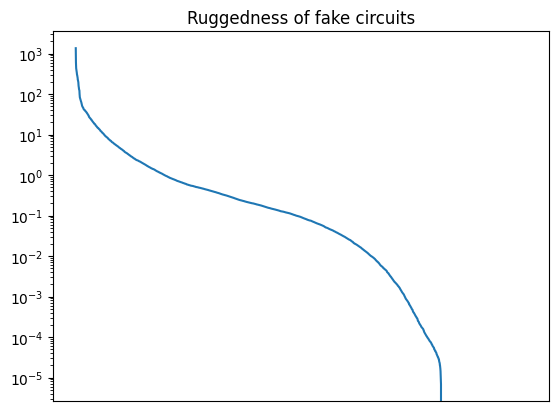

In [142]:
fake_circuits_f = fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)
n_interactions = fake_circuits_f.shape[-1]
ruggedness_loaded = np.load(os.path.join(
    'data/07_ruggedness/2025_01_26__13_32_02', 'ruggedness.npy'))
ruggedness_log = np.where(np.abs(np.log10(ruggedness_loaded)) < np.inf, np.log10(ruggedness_loaded), -6)
analytics_perturbed = load_json_as_dict(os.path.join(
    'data/07_ruggedness/2025_01_26__13_32_02', 'analytics.json'))
analytic_perturbed = np.log10(np.array(analytics_perturbed['sensitivity_wrt_species-6']))
analytic_og = np.log10(np.array(analytics['sensitivity_wrt_species-6']))
eps_perc = 1e-3
eps = eps_perc * np.abs(fake_circuits_f).max()
dp = (analytic_perturbed.reshape(n_interactions, len(analytic_og), -1) - 
      analytic_og[None, ...]) / eps
output_idx = -1
sns.lineplot(x=np.arange(len(fake_circuits_f)), y=np.sort(
    ruggedness_loaded[:, output_idx])[::-1])
plt.yscale('log')
plt.title('Ruggedness of fake circuits')
plt.xticks([])

In [138]:
np.nanmax(dp[..., output_idx]), np.nanmin(dp[..., output_idx]), dp.shape

(np.float64(253.8318198189405), np.float64(-250.21533211737173), (6, 10000, 9))

In [53]:
print('Percentage of circuits with no change:', np.sum(dp * eps == 0) / np.prod(analytic_perturbed.shape))

Percentage of circuits with no change: 0.07518703703703704


Text(0.5, 1.0, 'Mean and STD of dp: RNA_2')

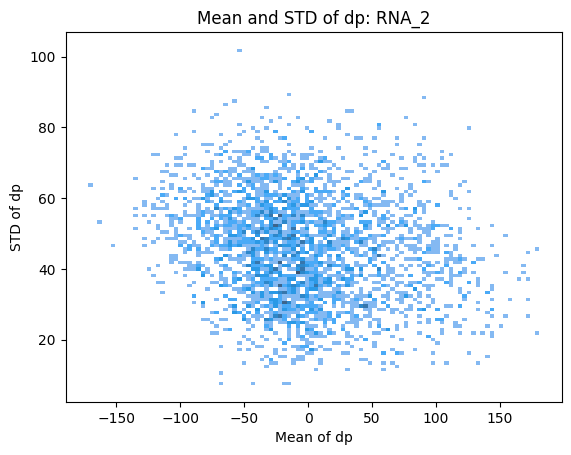

In [80]:
dp_mean = dp.mean(axis=0)
dp_std = dp.std(axis=0)

d1 = pd.DataFrame(data={'Mean of dp': dp_mean[:, -2], 'STD of dp': dp_std[:, -2]})
d2 = pd.DataFrame(data={'Mean of dp': dp_mean[:, -1], 'STD of dp': dp_std[:, -1]})
d1['Species'] = 'RNA_1'
d2['Species'] = 'RNA_2'
d = pd.concat([d1, d2]).reset_index(drop=True)
# sns.histplot(d, x='Mean of dp', y='STD of dp', hue='Species', bins=100, element='step')
sns.histplot(d[d['Species'] == 'RNA_2'], x='Mean of dp', y='STD of dp', bins=100, element='step')
# sns.kdeplot(d[d['Species'] == 'RNA_1'], x='Mean of dp', y='STD of dp', bins=100, element='step', alpha=0.7)
plt.title('Mean and STD of dp: RNA_2')

In [115]:
dp_sub = dp[..., -2:]
label_species = np.ones_like(dp_sub, dtype=object)
label_interactions = np.ones_like(dp_sub, dtype=object)
for i in range(dp_sub.shape[-1]):
    label_species[..., i] = f'RNA_{i+1}'

for ii, (i, j) in enumerate(sorted(set([tuple(np.sort([i, j]).tolist()) for i, j in itertools.product(np.arange(3), np.arange(3))]))):
    label_interactions[ii] = f'RNA_{i}-RNA_{j}'

<Axes: xlabel='Gradient of log sensitivity', ylabel='Count'>

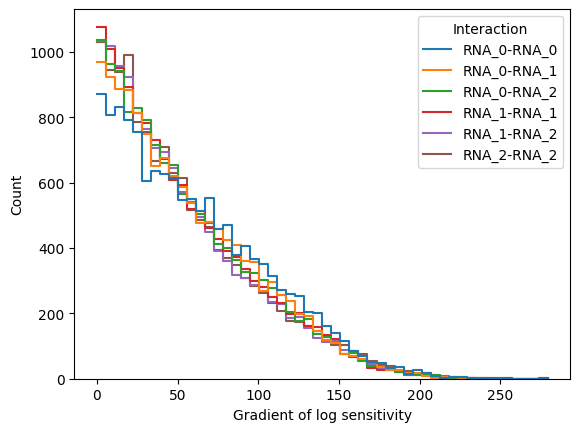

In [116]:
df = pd.DataFrame(data={'Gradient of log sensitivity': np.abs(dp_sub).flatten(), 
                        'Species': label_species.flatten(),
                        'Interaction': label_interactions.flatten()})
sns.histplot(df, x='Gradient of log sensitivity', hue='Interaction', bins=50, element='step', fill=False)


In [123]:
cond_rev = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sampled_cond, col=config_dataset.objective_col[0])

# Visualise TSNE

In [ ]:
h_all = encoder(params, rng, np.concatenate([fake_circuits, sampled_cond], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)

random_state = 0
perplexity = 30
tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, max_iter=1000)
tsne_result_2 = tsne.fit_transform(h_all)

<Axes: >

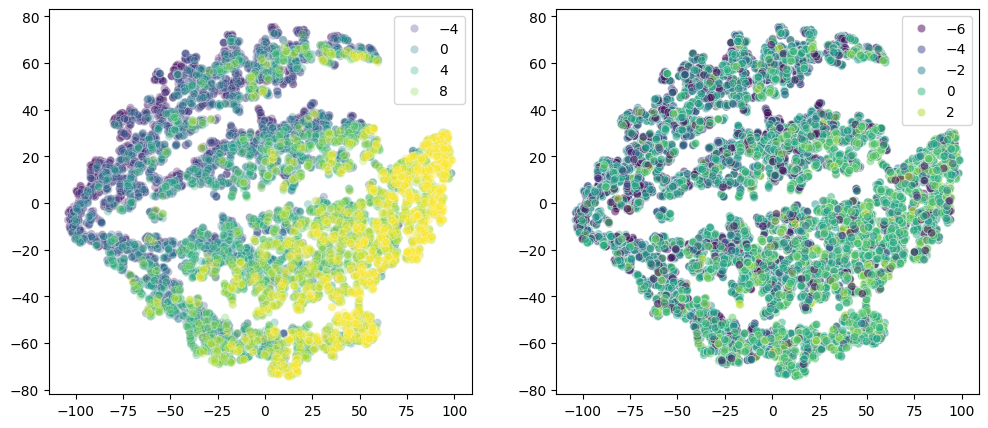

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=tsne_result_2[:, 0], y=tsne_result_2[:, 1], hue=cond_rev.reshape(np.prod(cond_rev.shape[:-1]), -1)[..., 0],
                palette='viridis', ax=axes[0], alpha=0.3)
sns.scatterplot(x=tsne_result_2[:, 0], y=tsne_result_2[:, 1], hue=ruggedness_log[..., -1],
                palette='viridis', ax=axes[1], alpha=0.5)

# Visualise PCA

In [149]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(h_all)

# # Plot the PCA result
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cond_rev.reshape(np.prod(cond_rev.shape[:-1]), -1)[..., 0], palette='viridis', alpha=0.3)
# plt.title('PCA of h_all with 2 components')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.show()

<Axes: >

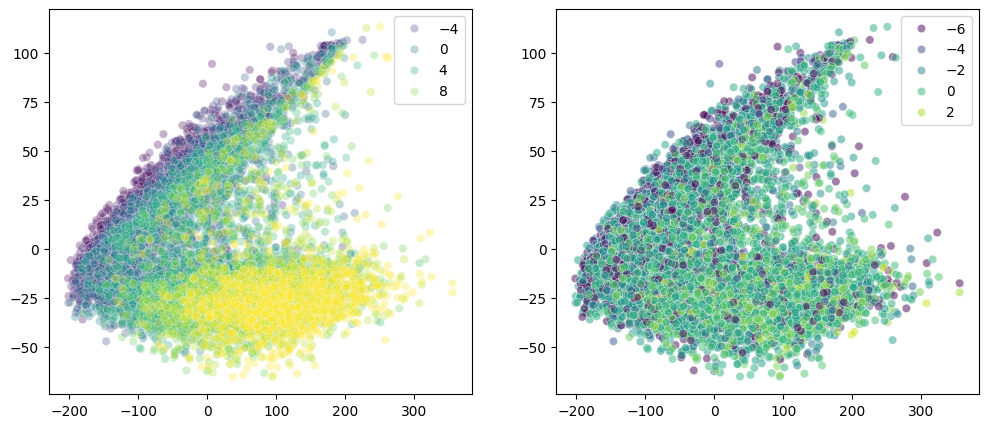

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cond_rev.reshape(np.prod(cond_rev.shape[:-1]), -1)[..., 0],
                palette='viridis', ax=axes[0], alpha=0.3)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=ruggedness_log[..., -1],
                palette='viridis', ax=axes[1], alpha=0.5)

In [104]:
import itertools
idxs_plot = sorted(set([tuple(np.sort([i, j]).tolist()) for i, j in itertools.product(np.arange(fake_circuits_f.shape[-1]), np.arange(fake_circuits_f.shape[-1])) if i != j]))
len(idxs_plot)

15

/tmp/ipykernel_1186065/3530162470.py:1: RuntimeWarning: divide by zero encountered in log10
  ruggedness_log = np.where(np.abs(np.log10(ruggedness_loaded)) < np.inf, np.log10(ruggedness_loaded), -6)


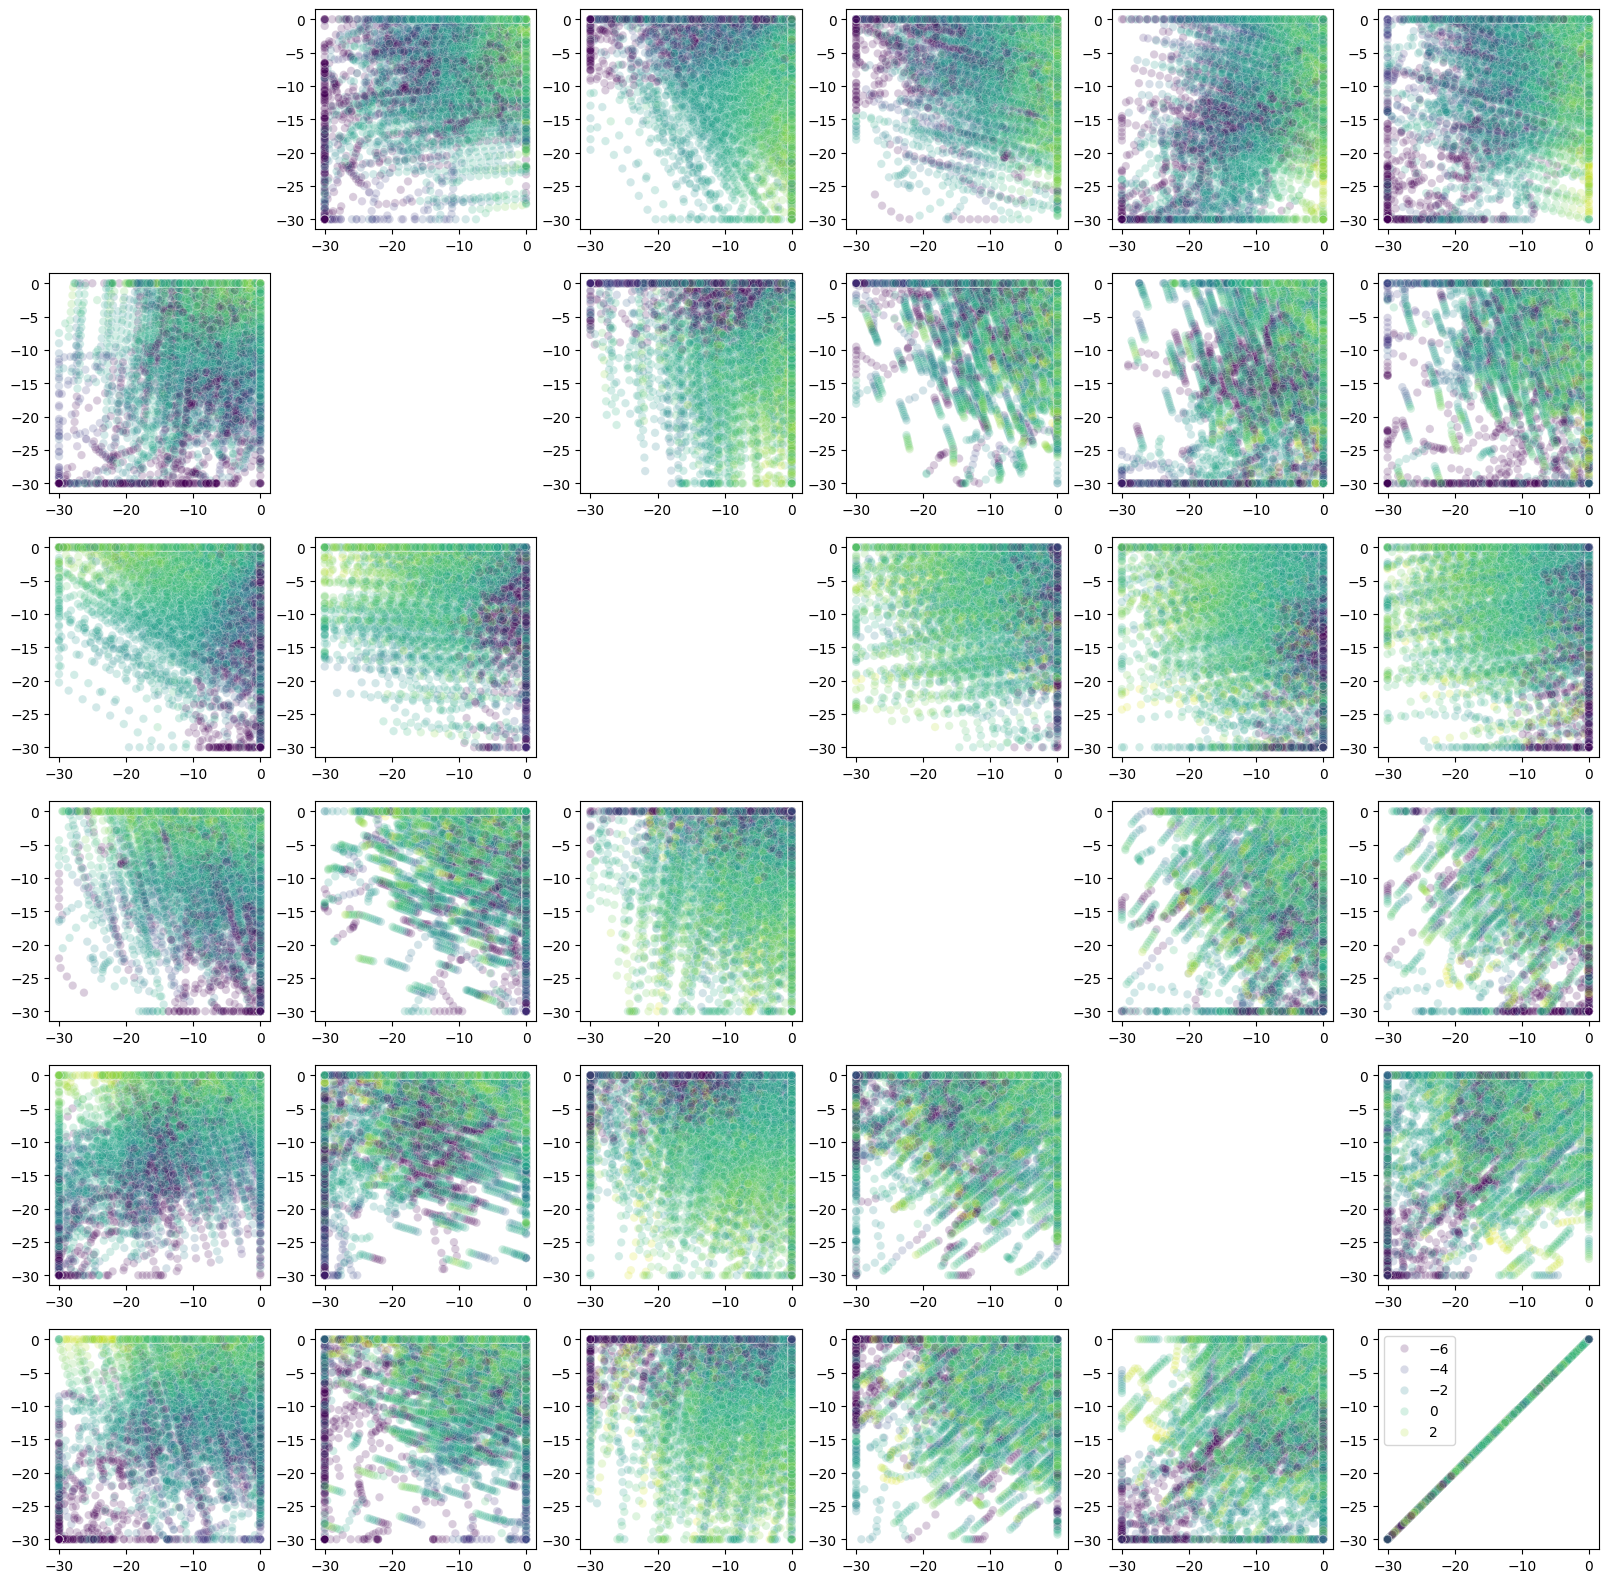

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(fake_circuits_f.shape[-1]):
    for j in range(fake_circuits_f.shape[-1]):
        is_final = (i == fake_circuits_f.shape[-1] - 1) & (j == fake_circuits_f.shape[-1] - 1)
        if i != j or is_final:
            plt.subplot(fake_circuits_f.shape[-1], fake_circuits_f.shape[-1], i * fake_circuits_f.shape[-1] + j + 1)
            sns.scatterplot(x=fake_circuits_f[:, i], y=fake_circuits_f[:, j], hue=ruggedness_log[:, output_idx], palette='viridis', alpha=0.2, legend=True if is_final else False)
            # sns.scatterplot(x=fake_circuits_f[:, i], y=fake_circuits_f[:, j], hue=None, palette='viridis', alpha=0.2, legend=True if is_final else False)